In [71]:
from os.path import join as opj
from nipype import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Info

In [74]:
experiment_dir = '/home/zohyos7/wellbeing_experiment'
output_dir = 'antsdir_2'
working_dir = 'workingdir_2'

# task name
task_list = ['empathy']

# Smoothing withds used during preprocessing
fwhm = [4, 8]

template = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

In [75]:
# Apply Transformation
apply_norm_bold = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply_norm_bold', iterfield=['input_image'])

apply_norm_anat = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply_norm_anat', iterfield=['input_image'])

In [76]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name','fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'bold': opj('/home/zohyos7/wellbeing_analysis/datasink/preproc', 'sub-{subject_id}', 'task-{task_name}',
                        'fwhm-{fwhm_id}_sasub-{subject_id}_task-{task_name}_bold.nii'),
             'anat': opj('/home/zohyos7/wellbeing_analysis/datasink/preproc', 'sub-{subject_id}', 'task-{task_name}', 
                         'sub-{subject_id}_T1w_brain.nii.gz'),
             'transform': opj('/home/zohyos7/wellbeing_experiment/antsdir/antsreg', '{subject_id}',
                         'transformComposite.h5')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders = ('_apply_norm%s/')
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [77]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('task_name', 'task_name'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, apply_norm_anat, [('anat', 'input_image'),
                                             ('transform', 'transforms')]),
                  (selectfiles, apply_norm_bold, [('bold', 'input_image'),
                                                 ('transform', 'transforms')]),
                  (apply_norm_anat, datasink, [('output_image', 'norm_ants.@anat')]),
                  (apply_norm_bold, datasink, [('output_image', 'norm_ants.@bold')])
                  ])

In [78]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='colored', format='png', simple_form=True)

180912-16:11:46,939 nipype.workflow INFO:
	 Generated workflow graph: /home/zohyos7/wellbeing_experiment/workingdir_2/antsflow/graph.png (graph2use=colored, simple_form=True).


'/home/zohyos7/wellbeing_experiment/workingdir_2/antsflow/graph.png'

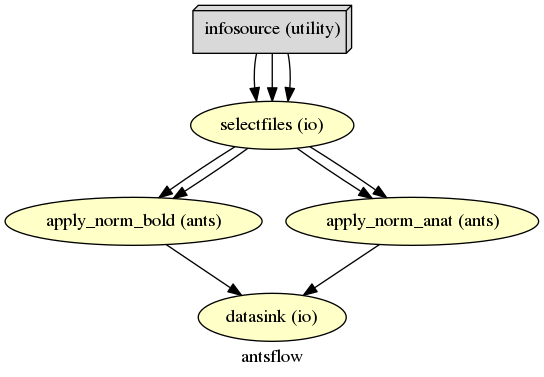

In [79]:
from IPython.display import Image
Image(filename='/home/zohyos7/wellbeing_experiment/workingdir_2/antsflow/graph.png')

In [80]:
antsflow.run('MultiProc', plugin_args={'n_procs': 8})

180912-16:11:53,106 nipype.workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging', 'monitoring']
180912-16:11:53,129 nipype.workflow INFO:
	 Running in parallel.
180912-16:11:53,166 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 8/8.
180912-16:11:53,364 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/home/zohyos7/wellbeing_experiment/workingdir_2/antsflow/_fwhm_id_8_subject_id_2855_task_name_empathy/selectfiles".180912-16:11:53,365 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/home/zohyos7/wellbeing_experiment/workingdir_2/antsflow/_fwhm_id_4_subject_id_2855_task_name_empathy/selectfiles".

180912-16:11:53,375 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")180912-16:11:53,377 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

180912-16:11:53,384 nipype.workflow INF

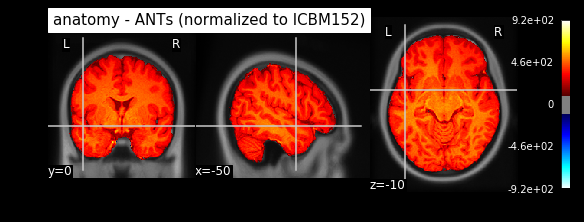

In [83]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
plot_stat_map(
    '/home/zohyos7/wellbeing_experiment/antsdir_2/norm_ants/sub-2855_fwhm4_task_name_empathy/_apply_norm_anat0/sub-2855_T1w_brain_trans.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img = '/home/zohyos7/fmri/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz',
    threshold=100, display_mode='ortho', cut_coords=(-50, 0, -10))